In [ ]:
import torch
import numpy as np
import pandas as pd


In [ ]:
def truncated_svd(A: torch.Tensor, truncate = 1):
  U, S, V = torch.linalg.svd(A, full_matrices= False)
  S[truncate*(-1):] = 0
  return U, torch.diag(S), V

In [ ]:
def cost_function(A, U, V):
  return torch.nn.functional.mse_loss(U@V, A, size_average=None, reduce=None, reduction='sum')

def gd_factorise_ad(A: torch.Tensor, rank: int, epochs = 1000, lr = 0.01):
  [m, n] = A.shape
  U = torch.rand((m, rank), dtype=float).clone().detach().requires_grad_(True)
  V = torch.rand((rank, n), dtype=float).clone().detach().requires_grad_(True)

  for epoch in range(epochs): 
    U.grad = None
    V.grad = None
    J = cost_function(A, U, V)
    J.backward()
    U.data = U - lr * U.grad
    V.data = V - lr * V.grad

  return U, V

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
+'iris/iris.data', header=None )
data = torch.tensor(df.iloc[:,[0, 1, 2, 3]].values)
data = data - data.mean(dim=0)

U, V = gd_factorise_ad(data, 2)
reconError = torch.nn.functional.mse_loss(U@V, data, size_average=None, reduce=None, reduction='sum')
print(reconError.item())

15.228845940286346


In [ ]:
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
U_1, S_1, V_1 = truncated_svd(data, 2)
truncReconError = torch.nn.functional.mse_loss(U_1@S_1@V_1, data, size_average=None, reduce=None, reduction='sum')
print(truncReconError.item())

15.228833347803324


In [ ]:
def pca_dim_reduction(X, M):
  #assert X.ndims <= M, "M has to be less than dimensionality of X!"
  
  # * 1. Center Data
  #X_mean = np.mean(X)
  #X_centered = X - X_mean
  
  # * 2. Compute Covariance Matrix
  X_cov = np.cov(X.T)
  
  # * 3.1. Get Eigen Values and Vectors
  eigen_values, eigen_vectors = np.linalg.eig(X_cov)
  # * 3.2. Get the top M eigen values indices
  top_M_idx = np.argsort(eigen_values)[::-1][:M]

  # * 4.1 Get top M Eigen Vectors
  top_M_eigen_vectors = eigen_vectors[:,top_M_idx]
  
  # * 4.2 return projections in reduced space
  return np.dot(X, top_M_eigen_vectors) 

In [ ]:
projected_data = pca_dim_reduction(data, 2)

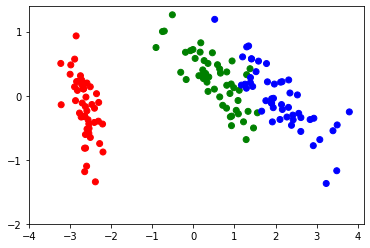

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

U_svd, S_svd, _ = torch.linalg.svd(data, full_matrices=False)
X_svd = U_svd@torch.diag(S_svd)

colors = {'Iris-setosa':'red', 'Iris-versicolor':'green', 'Iris-virginica':'blue'}
plt.scatter(X_svd[:,0], X_svd[:,1], c=df[4].map(colors))
#plt.title("Orthogonal linear transform data projection")
plt.xticks(range(-4,5))
plt.yticks(range(-2,2))
plt.show()

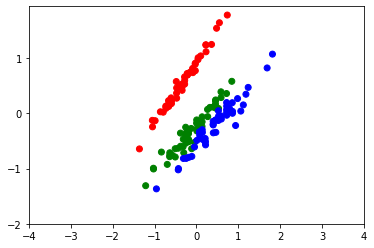

In [ ]:
reconstruction_approx_U = U.detach().numpy()
plt.scatter(reconstruction_approx_U[:,0], reconstruction_approx_U[:,1], c=df[4].map(colors))
#plt.title("Projection of data approximated through minimising reconstruction error")
plt.xticks(range(-4,5))
plt.yticks(range(-2,2))
plt.show()

# **A simple MLP**

In [ ]:
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
+'iris/iris.data', header=None )

df = df.sample(frac=1)

mapping = {k : v for v , k in enumerate(df[4].unique()) }
df[5] = df[4].map(mapping)

In [ ]:
alldata = torch.tensor(df.iloc[:,[ 0 , 1 , 2 , 3 ]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)


In [ ]:
targets_tr = torch.tensor(df.iloc[: 100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100: ]

In [ ]:
def loss_function(logits, targets):
  return torch.nn.functional.cross_entropy(logits, targets)

def mlp (data, targets, lr = 0.01, epochs = 100):
  W1 = torch.rand((4, 12), dtype=torch.float).clone().detach().requires_grad_(True)
  W2 = torch.rand((12, 3), dtype=torch.float).clone().detach().requires_grad_(True)
  b1 = torch.tensor(0, requires_grad=True, dtype=torch.float)
  b2 = torch.tensor(0, requires_grad=True, dtype=torch.float)

  for epoch in range(epochs):
    #optimizer.zero_grad(set_to_none=True)
    W1.grad = None
    W2.grad = None
    b1.grad = None
    b2.grad = None
    logits = torch.relu(data @ W1 + b1) @ W2 + b2
    J = loss_function(logits, targets)
    J.backward()
    W1.data = W1 - lr * W1.grad
    W2.data = W2 - lr * W2.grad
    b1.data = b1 - lr * b1.grad
    b2.data = b2 - lr * b2.grad

  return W1, W2, b1, b2

In [ ]:
def model_train (data, targets):
  return mlp(data, targets)

def model_predict(data, W1, W2, b1, b2):
  logits = torch.relu(data @ W1 + b1) @ W2 + b2
  return torch.argmax(logits, dim=1)

In [ ]:
W1, W2, b1, b2 = model_train(data_tr, targets_tr)

y_pred_tr = model_predict(data_tr, W1, W2, b1, b2)
y_pred = model_predict(data_va, W1, W2, b1, b2)

print("Training acc = " + str(accuracy_score(y_pred_tr, targets_tr).item()))
print("Validation acc = " + str(accuracy_score(y_pred, targets_va).item()))

Training acc = 0.59
Validation acc = 0.6
